# step 57 conv2d 함수와 pooling 함수

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
my_path = '/content/notebooks'
# 구글드라이브 deep-learning-from-scratch-3-master 폴더에 있는 패키지를 colab에 심볼링크걸린 notebooks 폴더 생성 
os.symlink('/content/drive/MyDrive/Colab Notebooks/deep-learning-from-scratch-3-master', my_path)
# 파이썬 모듈 검색 경로추가
sys.path.insert(0, my_path)

## 57.1 im2col에 의한 전개

### 477~479 그림

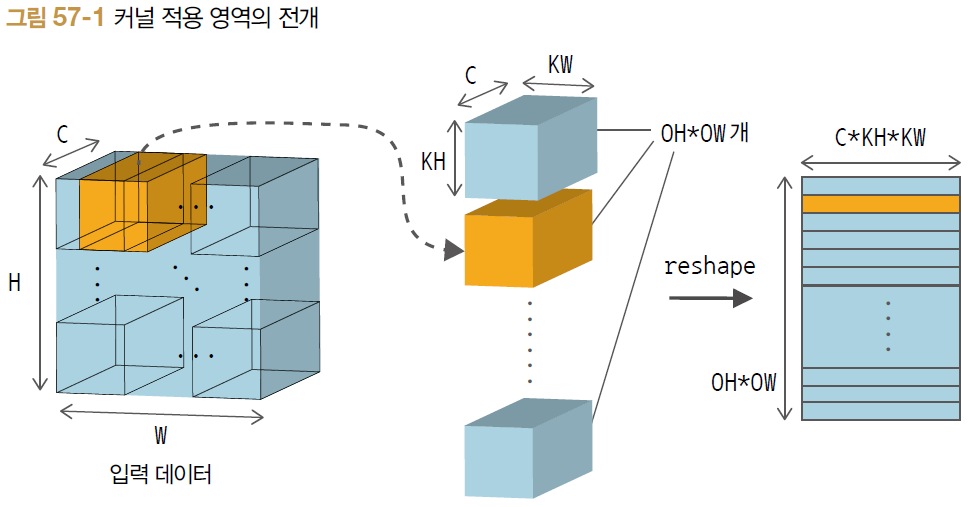

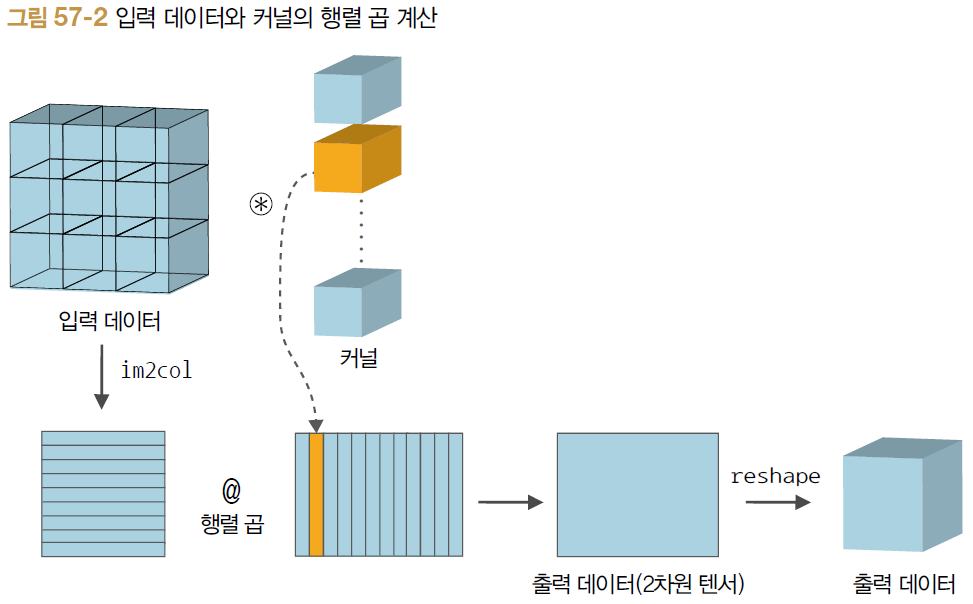

## 57.2 conv2d 함수 구현

### 479~480 그림

- im2col  인터페이스

  + im2col(x, kernel_size, stride=1, pad=0, to_matrix=True)

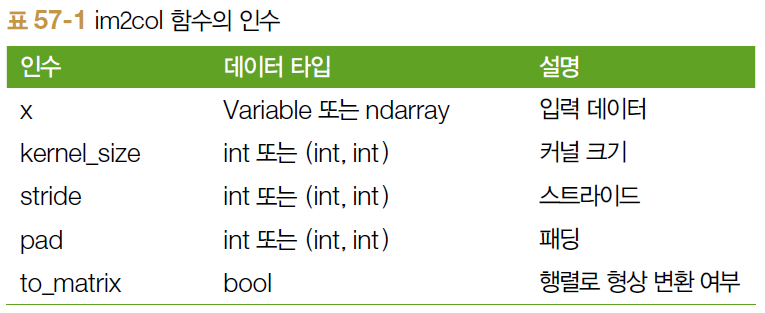

In [ ]:
# steps/step57.py

import numpy as np
import dezero.functions as F

x1 = np.random.rand(1, 3, 7, 7) # 배치 크기 = 1
col1 = F.im2col(x1, kernel_size=5, stride=1, pad=0, to_matrix=True)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7) # 배치 크기 = 10
kernel_size = (5, 5)
stride = (1, 1)
pad = (0, 0)
col2 = F.im2col(x2, kernel_size, stride, pad, to_matrix=True)
print(col2.shape)

(9, 75)
(90, 75)


### 481

In [ ]:
# dezero/utils.py

def pair(x):
  if isinstance(x, int):
    return (x, x)
  elif isinstance(x, tuple):
    assert len(x) == 2
    return x
  else:
    raise ValueError

In [ ]:
from dezero.utils import pair

print(pair(1))
print(pair((1, 2)))

(1, 1)
(1, 2)


### 482

In [ ]:
# dezero/functions_conv.py

from dezero.utils import pair, get_conv_outsize

def conv2d_simple(x, W, b=None, stride=1, pad=0):
  x, W = as_variable(x), as_variable(W)

  Weight = W  # Widthd의 'W'와 헷갈리지 않기 위해
  N, C, H, W = x.shape
  OC, C, KH, KW = Weight.shape
  SH, SW = pair(stride)
  PH, PW = pari(pad)
  OH = get_conv_outsize(H, KH, SH, PH)
  OW = get_conv_outsize(W, KW, SW, PW)

  col = im2col(x, (KH, KW), stride, pad, to_matrix=True) # 전개 # 추가
  Weight = Weight.reshape(OC, -1).transpose()  # 재정렬 # 추가
  t = linear(col, Weight, b)  # 행렬 곱 계산 # 추가
  y = t.reshape(N, OH, OW, OC).transpose(0, 3, 1, 2)  # 축 순서 바꿈 # 추가
  return y

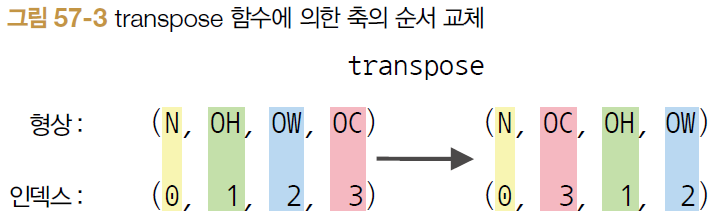

### 483 step/step57.py

In [ ]:
# step/step57.py

from dezero import Variable  # 실행하기 위해

N, C, H, W = 1, 5, 15, 15
OC, (KH, KW) = 8, (3, 3)

x = Variable(np.random.randn(N, C, H, W))
W = np.random.randn(OC, C, KH, KW)
y = F.conv2d_simple(x, W, b=None, stride=1, pad=1)
y.backward()

print(y.shape)
print(x.grad.shape)

(1, 8, 15, 15)
(1, 5, 15, 15)


## 57.3 Conv2d 계층 구현


### 484

In [ ]:
# dezero/layers.py

from dezero import Layer  # 실행하기 위해

class Conv2d(Layer):
  def __init__(self, out_channels, kernel_size, stride=1, pad=0, nobias=False, dtype=np.float32, in_channels=None):
    super().__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.stride = stride
    self.pad = pad
    self.dtype = dtype

    self.W = Parameter(None, name='W')
    if in_channels is not None:
      self._init_W()

    if nobias:
      self.b = None
    else:
      self.b = Parameter(np.zeros(out_channels, dtype=dtype), name='b')

  def _init_W(self, xp=np):
    C, OC = self.in_chanels, self.out_channels
    KH, KW = pair(self.kernel_size)
    scale = np.sqrt(1 / (C * KH * KW))
    W_data = xp.random.randn(OC, C, KH, KW).astype(self.dtype) * scale
    self.W.data = W_data

  def forward(self, x):
    if self.W.data is None:
      self.in_channels = x.shape[1]
      xp = cuda.get_array_module(x)
      self._init_W(xp)

    y = F.conv2d_simple(x, self.W, self.b, self.stride, self.pad)
    # 또는 y = F.conv2d(x, self.W, self.b, self.stride, self.pad)
    return y

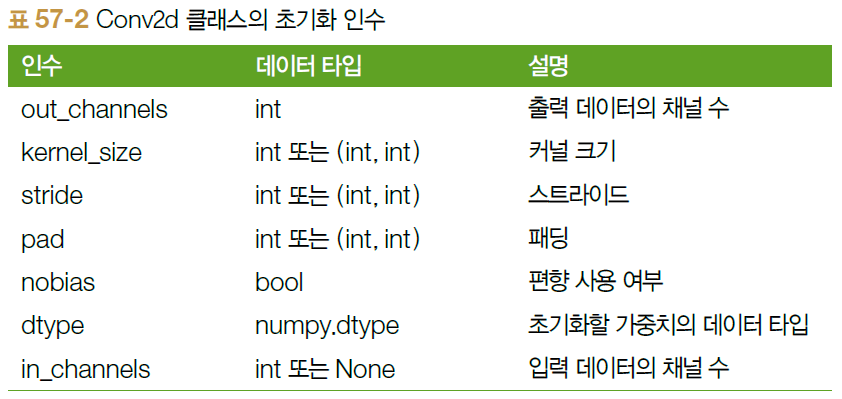

## 57.4 pooling 함수 구현

### 485~486 그림

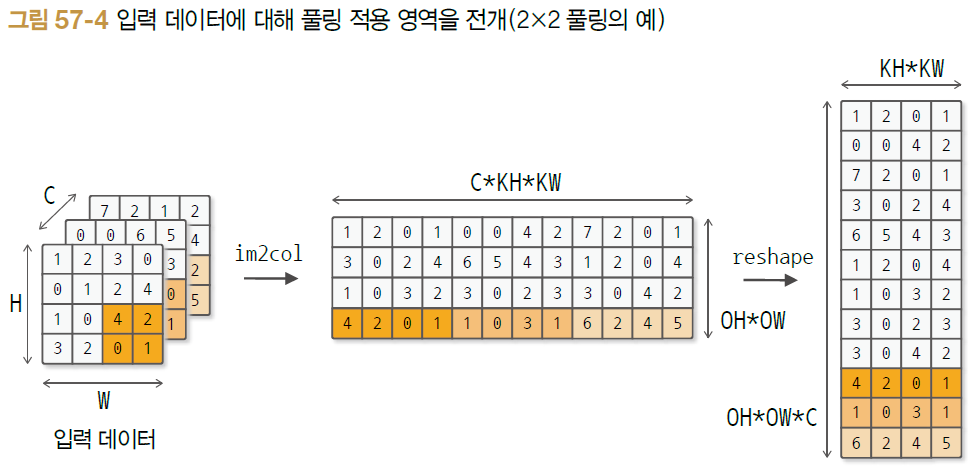

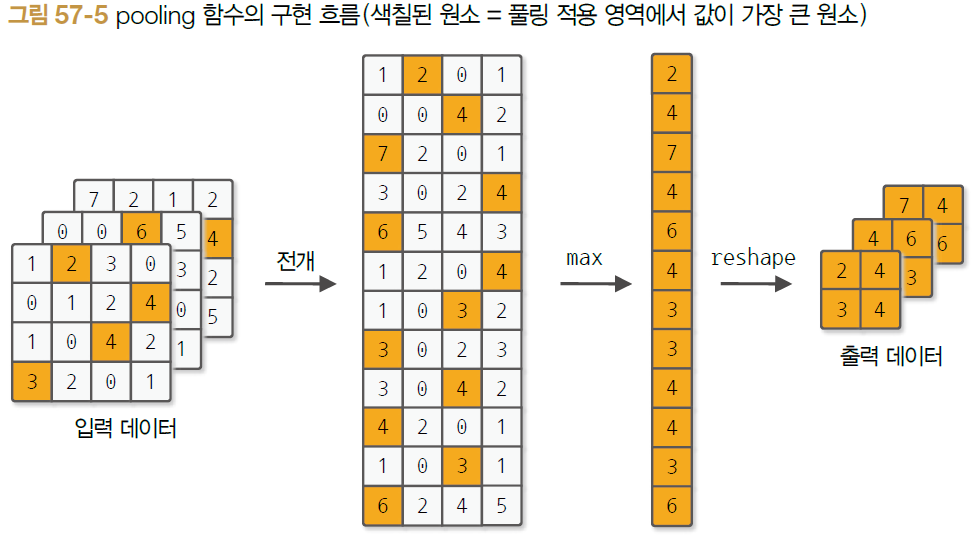

In [ ]:
# dezero/functions_conv.py

def pooling_simple(x, kernel_size, stride=1, pad=0):
  x = as_variable(x)

  N, C, H, W = x.shape
  KH, KW = pair(kernel_size)
  PH, PW = pair(pad)
  SH, SW = pair(stride)
  OH = get_conv_outsize(H, KH, SH, PH)
  OW = get_conv_outsize(W, KW, SW, PW)

  col = im2col(x, kernel_size, stride, pad, to_matrix=True)  # 전개 # 추가
  col = col.reshape(-1, KH, * KW)  # 추가
  y = col.max(axis=1)  # 최대값 # 추가
  y = y.reshape(N, OH, OW, C).transpose(0, 3, 1, 2)  # 형상 변환 # 추가
  return y